<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/04_Named_Entity_Recognition/BERN2.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# BERN2 (Advanced Biomedical Entity Recognition and Normalization)

## 1. Introduction

[BERN2](https://github.com/dmis-lab/BERN2) is an advanced neural biomedical named entity recognition and normalisation tool developed by the Data Mining & Information Systems (DMIS) Laboratory at Korea University. It improves on [BERN](https://github.com/dmis-lab/BERN), the previous BioBERT-based multi-type NER and named
 entity normalisation (NEN) tool, by employing a multi-task NER model and neural network-based NEN models to achieve much faster and more accurate inference. It is an end-to-end entity linking model which performs NER and NEN (also known as entity linking or grounding) in a single step unlike scispaCy which requires loading a pretrained NER model to extract entities and then an EntityLinker component to link to one of the supported knowledge bases.

The BERN2 model addresses various challenges and limitations of existing biomedical text mining tools as outlined in the [research paper](https://academic.oup.com/bioinformatics/article/38/20/4837/6687126):

*  models' ability to annotate only a few biomedical entity types is overcome by supporting nine (Gene/Protein, Disease, Drug/Chemical, Species, Mutation, Cell Line, Cell Type, DNA, and RNA);

* use of multiple single-type NER models to annotate different entity types is surpassed by a single multi-task NER model supporting efficient parallel inference and dramatically reducing the annotation time;

* NEN models based purely on pre-defined rules, with dictionaries which cannot normalise entities into their canonical mention unless explicitly contained in the dictionary, are replaced by a hybrid approach combining rule-based and neural network-based NEN models. BERN2 first tries rule-based normalisation on each named entity and only the ones that were not normalised by the rule-based models are then normalised by [BioSyn](https://github.com/dmis-lab/BioSyn) (Biomedical Entity Representations with Synonym Marginalization).




## 2. Install/import libraries

In [ ]:
!pip install spacy scispacy swifter

In [ ]:
# scispaCy small model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import spacy
import scispacy
import requests
import hashlib
import swifter
import warnings
warnings.filterwarnings("ignore")

from multiprocessing.pool import ThreadPool
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker

## 3. BERN2 API

BERN2 can be installed and run locally, and accessed via the RESTful API, which is recommended for bulk requests. It can also be used without installing locally via the web service where the API limit is 300 requests per 100 seconds.

We will define a function to call the API endpoint and then call it to extract named entities and CUIs for some test sentences.


In [ ]:
def query_plain(text: str):
    """Biomedical entity linking API"""

    # BERN2 API for cloud service
    url="http://bern2.korea.ac.kr/plain"

    if isinstance(text, str):
        response = requests.post(url, json={'text': text}).json()
    else:
      raise TypeError("Need to supply text")

    return response

In [ ]:
def get_entities(text: str):

    entity_list = []

    for sentence in text:
        entity_list.append(query_plain(sentence))

    return entity_list

### NER and Linking

In [ ]:
# create a list of two test sentences
text0 ='Likewise, another study showed that repurposed drugs such as pralatrexate, carumonam, aclerasteride, and granotapide interacted with spike protein of SARS-CoV-2 and acted as potential binders.'
text1 ='In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year.'

texts = [text0, text1]

In [ ]:
%%time

entity_list = get_entities(texts)

CPU times: user 43.5 ms, sys: 3.42 ms, total: 46.9 ms
Wall time: 3.94 s


The output is in JSON format for each sentence and contains the concept unique identifier (CUI) in the target knowledge base for each mention where this is available, the entity type, the match score, and start and end spans of the mention.

The key `is_neural_normalized` has a Boolean value of False if the named entity was normalised by the rule-based models, and True if it was normalised by BioSyn. [Bioregistry](https://bioregistry.io/) is used to standardise prefixes for normalised entity identifiers. For example the CUI with prefix for 'hydroxychloroquine'  would be `[mesh:D006886]` which could then be appended to the bioregistry domain to redirect to the target knowledge base entry: https://bioregistry.io/mesh:D006886



In [ ]:
entity_list

[{'annotations': [{'id': ['mesh:C418863'],
    'is_neural_normalized': False,
    'mention': 'pralatrexate',
    'obj': 'drug',
    'prob': 0.9994994401931763,
    'span': {'begin': 61, 'end': 73}},
   {'id': ['mesh:C044145'],
    'is_neural_normalized': False,
    'mention': 'carumonam',
    'obj': 'drug',
    'prob': 0.9987694621086121,
    'span': {'begin': 75, 'end': 84}},
   {'id': ['mesh:C003938'],
    'is_neural_normalized': True,
    'mention': 'aclerasteride',
    'obj': 'drug',
    'prob': 0.9988576173782349,
    'span': {'begin': 86, 'end': 99}},
   {'id': ['mesh:C556241'],
    'is_neural_normalized': False,
    'mention': 'granotapide',
    'obj': 'drug',
    'prob': 0.9995781779289246,
    'span': {'begin': 105, 'end': 116}},
   {'id': ['NCBIGene:124512'],
    'is_neural_normalized': True,
    'mention': 'spike protein',
    'obj': 'gene',
    'prob': 0.9030604362487793,
    'span': {'begin': 133, 'end': 146}},
   {'id': ['mesh:D045169'],
    'is_neural_normalized': False,

In [ ]:
with open('2024-03-23_bern2_entity_list_test.pickle', 'wb') as f:
  pickle.dump(entity_list, f)

### Visualise NER labels

We will use spaCy's displaCy named entity visualiser with custom colours for the entity types to highlight the named entities and their labels.




In [ ]:
colors = {'disease': 'linear-gradient(90deg, #66ffcc, #abf763)',
          'drug': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)',
          "gene":'linear-gradient(90deg, #ffff66, #ff6600)',
          'species': 'linear-gradient(90deg, #6699ff, #99ccff)',
          'cell_line': 'linear-gradient(90deg, #ff99cc, #ffcccc)',
          'cell_type': 'linear-gradient(90deg, #99ff99, #66ff66)',
          'DNA': 'linear-gradient(90deg, #ff6666, #ff9999)'}

In [ ]:
def get_entities_html(entity_list, title=None):
    """Visualise NER with the help of spaCy"""
    render_data_list = []
    options = {"colors": colors} if colors else {}

    for ent in entity_list:
        ents = []
        for annotation in ent['annotations']:
            e = {
                "start": annotation['span']['begin'],
                "end": annotation['span']['end'],
                "label": annotation['obj']
            }
            ents.append(e)

        render_data = {
            "text": ent['text'],
            "ents": ents,
            "title": title
        }
        render_data_list.append(render_data)

    spacy.displacy.render(render_data_list, style="ent", manual=True, jupyter=True, options=options)

In [ ]:
entities_html = get_entities_html(entity_list)

The repurposed drugs and spike protein have been correctly labelled as `drug` and `gene` respectively. However, there is some overlap and inconsistency with COVID-related nested entities where substrings are labelled in addition to the complete entity or, in some cases, not identified at all. In the first sentence the nested entity 'SARS' is labelled as `disease` but in the second sentence as `species`.

We can also see this if we try extracting entities from the same sample text using the [BERN2 web app](http://bern2.korea.ac.kr/).

![BERN2 web app screenshot](images/BERN2_web_app.png)

An important consideration for BioNER models is how well they can generalise to unseen mentions. [Kim, H. and Kang, J. (2022)](https://pmc.ncbi.nlm.nih.gov/articles/PMC9014470/) define three types of recognition abilities BioNER models should possess:

* Memorisation: the ability to identify the entity mentions that were seen during training.

* Synonym generalisation: being robust to morphological variations where biomedical names are expressed in various forms even when referring to the same concepts.

* Concept generalisation: the ability to generalise to novel entities or concepts that did not exist before, such as COVID-19, which do not follow conventional surface patterns or context making them difficult to identify.

Another study by [Kühnel, L. and Fluck, J. (2022)](https://pmc.ncbi.nlm.nih.gov/articles/PMC9612606/) concludes that BioNER is much more complex than solving tasks on general domain knowledge. For the six disease NER algorithms investigated, BioNER applied on COVID-19 preprints showed a performance drop compared to the results on test data, with the models lacking sufficient generalisation capabilities for predicting on unseen data.



We will try again using the sentence above with COVID-related entities and another with potential nested entities for comparison.



In [ ]:
# create a list of two test sentences
text0 = "In the context of the pandemic in that year, there was a surge in research on the subject, with COVID-19/SARS-CoV-2/Coronavirus topping the list of keywords as soon as COVID-19/SARS-CoV-2/Coronavirus appeared that year."
text1 = "We used gene expression profiles of SARS-CoV-2 infected samples and a control group from alveolar type II cells and African green monkey kidney cells."

In [ ]:
texts = [text0, text1]

In [ ]:
%%time

entity_list = get_entities(texts)

CPU times: user 34.8 ms, sys: 7.01 ms, total: 41.8 ms
Wall time: 4.16 s


In [ ]:
entity_list

[{'annotations': [{'id': ['mesh:D000086382'],
    'is_neural_normalized': False,
    'mention': 'COVID-19',
    'obj': 'disease',
    'prob': 0.7654341459274292,
    'span': {'begin': 96, 'end': 104}},
   {'id': ['CUI-less'],
    'is_neural_normalized': False,
    'mention': 'SARS',
    'obj': 'species',
    'prob': 0.6938016414642334,
    'span': {'begin': 105, 'end': 109}},
   {'id': ['mesh:D000086382'],
    'is_neural_normalized': False,
    'mention': 'COVID-19',
    'obj': 'disease',
    'prob': 0.9846715927124023,
    'span': {'begin': 168, 'end': 176}},
   {'id': ['mesh:D045169'],
    'is_neural_normalized': True,
    'mention': 'SARS-CoV',
    'obj': 'disease',
    'prob': 0.8531102538108826,
    'span': {'begin': 177, 'end': 185}},
   {'id': ['CUI-less'],
    'is_neural_normalized': False,
    'mention': 'SARS-CoV-2',
    'obj': 'species',
    'prob': 0.8511154651641846,
    'span': {'begin': 177, 'end': 187}},
   {'id': ['mesh:D000086382'],
    'is_neural_normalized': False,


In [ ]:
entities_html = get_entities_html(entity_list)

We can see that in the second sentence the nested entity 'SARS-CoV' is labelled `disease` and 'SARS-CoV-2' as `species` as per the second mention of `SARS-CoV-2' in the first sentence.

In the second sentence there is a deeply nested example with 'African green', 'African green monkey', and the entity we actually want to extract - 'African green monkey kidney cells'. Overlapping entities are not being merged by the model.

![BERN2 web app screenshot 2](images/BERN2_web_app_2.png)



### NER and Linking for 10 articles

We will extract the named entities and labels for coreference resolved text for 10 articles.

In [ ]:
# load data for 10 articles
with open('2024-07-25_pmc_arxiv_full_sent_text_spacy_sent_coref_df.pickle', 'rb') as f:
  pmc_arxiv_full_sent_text_spacy_fastcoref = pickle.load(f)

In [ ]:
%%time

with ThreadPool(4) as pool:
     entity_list = pool.map(get_entities, pmc_arxiv_full_sent_text_spacy_fastcoref.sent_coref_text)

CPU times: user 3.76 s, sys: 524 ms, total: 4.28 s
Wall time: 13min 17s


In [ ]:
with open('2023-06-02_bern2_entity_list_sent_coref_text_0-10.pickle', 'wb') as f:
  pickle.dump(entity_list, f)

In [ ]:
len(entity_list)

10

In [ ]:
# JSON output for first article
entity_list[0]

[{'annotations': [],
  'text': 'Sir James Black, a winner of the 1988 Nobel Prize, clearly recognized well before the 21st century that drug repurposing strategies would occupy an important place in the future of new drug discovery.',
  'timestamp': 'Fri Jun 02 14:07:21 +0000 2023'},
 {'annotations': [],
  'text': 'In 2004, Ted T. Ashburn et al. summarized previous research and developed a general approach to drug development using drug repurposing, retrospectively looking for new indications for approved drugs and molecules that are waiting for approval for new pathways of action and targets.',
  'timestamp': 'Fri Jun 02 14:07:23 +0000 2023'},
 {'annotations': [],
  'text': 'molecules that are waiting for approval for new pathways of action and targets are usually safe in clinical trials but do not show sufficient efficacy for the treatment of the disease originally targeted.',
  'timestamp': 'Fri Jun 02 14:07:23 +0000 2023'},
 {'annotations': [],
  'text': 'The definition of the term

The JSON output for the first article shows an empty annotations list for sentences where no entities were found. Where the model labelled an entity but was unable to assign a target knowledge base id it returns `'id': ['CUI-less']`.

### Parsed entities

The following function checks whether the id is not CUI-less. If not, it returns the id(s) mapping to knowledge bases e.g. `'entity_id': ['mim:254500', 'mesh:D009101']`. If so, it replaces CUI-less with the entity name as the id. By accessing the 'span' dictionary from the entity dictionary we can also add the start and end spans for each entity.

The sha256 secure hash algorithm will also be computed for each sentence as a unique identifier which may be useful for the relation extraction step in the pipeline.

In [ ]:
def get_parsed_entities(entity_list):
    parsed_entities = []
    for entities in entity_list:
      e = []
      # If there are not entities in the text
      if not entities.get('annotations'):
        parsed_entities.append({'text':entities['text'], 'text_sha256': hashlib.sha256(entities['text'].encode('utf-8')).hexdigest()})
        continue
      for entity in entities['annotations']:
        entity_id = [id for id in entity['id'] if not id.startswith("CUI-less")]
        entity_type = entity['obj']
        entity_name = entities['text'][entity['span']['begin']:entity['span']['end']]
        span_dict = entity.get('span', {})  # Accessing the 'span' dictionary from the entity dictionary
        span_start = span_dict.get('begin')
        span_end = span_dict.get('end')
        if entity['id']  == ['CUI-less']:
           entity_id = entity_name
        e.append({'entity_id': entity_id, 'entity_type': entity_type, 'entity': entity_name, 'span_start': span_start, 'span_end': span_end})
      parsed_entities.append({'entities': e, 'text': entities['text'], 'text_sha256': hashlib.sha256(entities['text'].encode('utf-8')).hexdigest()})

    return parsed_entities

In [ ]:
parsed_entities = list(map(get_parsed_entities, entity_list))

In [ ]:
len(parsed_entities)

10

In [ ]:
with open('2024-03-27_parsed_entities_spans_0-10.pickle', 'wb') as f:
  pickle.dump(parsed_entities, f)

In [ ]:
parsed_entities[0]

[{'text': 'Sir James Black, a winner of the 1988 Nobel Prize, clearly recognized well before the 21st century that drug repurposing strategies would occupy an important place in the future of new drug discovery.',
  'text_sha256': '3fa4b49ec4ff4e82b35d2e3ef94c6bc460f3da8c6899a095d5837039682b493d'},
 {'text': 'In 2004, Ted T. Ashburn et al. summarized previous research and developed a general approach to drug development using drug repurposing, retrospectively looking for new indications for approved drugs and molecules that are waiting for approval for new pathways of action and targets.',
  'text_sha256': '86134a5f8a35a56cfdda5f5a671ceab374eb8b2e32a066ff0f62cc006d113059'},
 {'text': 'molecules that are waiting for approval for new pathways of action and targets are usually safe in clinical trials but do not show sufficient efficacy for the treatment of the disease originally targeted.',
  'text_sha256': '88af2843e742ba0259d51736e846796e360e0ba2bb47a3dc3e78270fefc6006c'},
 {'text': 'Th

We will also add the article_id to the JSON output to easily identify which article the individual sentences are from.

In [ ]:
pmc_arxiv_full_sent_text_spacy_fastcoref.article_id.head(10)

,article_id
0,PMC9549161
1,PMC9539342
2,PMC9357751
3,PMC9346052
4,PMC9775208
5,PMC9527439
6,PMC9729590
7,PMC9236981
8,PMC9694939
9,PMC9556799


In [ ]:
def add_article_id_all(parsed_sents_list, df):
    modified_sents_list = []
    for i, article_data in enumerate(parsed_sents_list):
        article_id = df.iloc[i]['article_id']
        modified_article_data = []  # Initialise modified data for the current article

        for sentence in article_data:
            if isinstance(sentence, dict) and 'text' in sentence:
                # Add the article_id to the sentence dictionary
                sentence['article_id'] = article_id
                modified_article_data.append(sentence)

        modified_sents_list.append(modified_article_data)

    return modified_sents_list

In [ ]:
all_sents_article_id = add_article_id_all(parsed_entities, pmc_arxiv_full_sent_text_spacy_fastcoref)

In [ ]:
len(all_sents_article_id)

10

In [ ]:
with open('2024-10-19_bern2_entity_list_sent_coref_text_parsed_entities_without_other_ids_spans_article_id.pickle', 'wb') as f:
   pickle.dump(all_sents_article_id, f)

In [ ]:
all_sents_article_id[0]

[{'text': 'Sir James Black, a winner of the 1988 Nobel Prize, clearly recognized well before the 21st century that drug repurposing strategies would occupy an important place in the future of new drug discovery.',
  'text_sha256': '3fa4b49ec4ff4e82b35d2e3ef94c6bc460f3da8c6899a095d5837039682b493d',
  'article_id': 'PMC9549161'},
 {'text': 'In 2004, Ted T. Ashburn et al. summarized previous research and developed a general approach to drug development using drug repurposing, retrospectively looking for new indications for approved drugs and molecules that are waiting for approval for new pathways of action and targets.',
  'text_sha256': '86134a5f8a35a56cfdda5f5a671ceab374eb8b2e32a066ff0f62cc006d113059',
  'article_id': 'PMC9549161'},
 {'text': 'molecules that are waiting for approval for new pathways of action and targets are usually safe in clinical trials but do not show sufficient efficacy for the treatment of the disease originally targeted.',
  'text_sha256': '88af2843e742ba0259d51

### Entities only

We will iterate over the list of articles and use a list comprehension to extract only the information for sentences with entities.

In [ ]:
entities_only = []

for article in all_sents_article_id:
    entities_only.append([item for item in article if 'entities' in item])

In [ ]:
len(entities_only)

10

In [ ]:
entities_only[0]

[{'entities': [{'entity_id': ['mesh:D000068677'],
    'entity_type': 'drug',
    'entity': 'sildenafil',
    'span_start': 38,
    'span_end': 48},
   {'entity_id': ['mesh:D007172'],
    'entity_type': 'disease',
    'entity': 'male erectile dysfunction',
    'span_start': 53,
    'span_end': 78},
   {'entity_id': ['mesh:D006976', 'mim:178600'],
    'entity_type': 'disease',
    'entity': 'pulmonary hypertension',
    'span_start': 83,
    'span_end': 105},
   {'entity_id': ['mesh:D016642'],
    'entity_type': 'drug',
    'entity': 'bupropion',
    'span_start': 144,
    'span_end': 153},
   {'entity_id': ['mesh:D013792'],
    'entity_type': 'drug',
    'entity': 'thalidomide',
    'span_start': 197,
    'span_end': 208},
   {'entity_id': ['mim:254500', 'mesh:D009101'],
    'entity_type': 'disease',
    'entity': 'multiple myeloma',
    'span_start': 213,
    'span_end': 229},
   {'entity_id': ['mesh:D006086'],
    'entity_type': 'disease',
    'entity': 'chronic graft-versus-host dise

In [ ]:
with open('2024-10-19_entities_only_spans_article_id_0-10.pickle', 'wb') as f:
  pickle.dump(entities_only, f)

We will convert the entities_only output above into a DataFrame.

In [ ]:
def get_entities_only(entities_only):

    entities_only_list = []

    for article in entities_only:
        for item in article:
            entities = item['entities']
            for entity in entities:
                entities_only_list.append({
                    'article_id': item['article_id'],
                    'entity_id': entity['entity_id'],
                    'entity_type': entity['entity_type'],
                    'entity': entity['entity'],
                    'span_start': entity['span_start'],
                    'span_end': entity['span_end'],
                    'text': item['text'],
                    'text_sha256': item['text_sha256']
                })

    entities_only_df = pd.DataFrame(entities_only_list, columns=['article_id', 'entity_id', 'entity_type', 'entity', 'span_start', 'span_end', 'text', 'text_sha256'])
    return entities_only_df

In [ ]:
entities_only_df = get_entities_only(entities_only)

In [ ]:
entities_only_df

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
0,PMC9549161,[mesh:D000068677],drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
1,PMC9549161,[mesh:D007172],disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
2,PMC9549161,"[mesh:D006976, mim:178600]",disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
3,PMC9549161,[mesh:D016642],drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
4,PMC9549161,[mesh:D013792],drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
...,...,...,...,...,...,...,...,...
4288,PMC9556799,African green,cell_line,African green,116,129,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4289,PMC9556799,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4290,PMC9556799,[NCBITaxon:9534],species,African green monkey,116,136,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4291,PMC9556799,up- and downregulated genes,DNA,up- and downregulated genes,20,47,We input the top-50 up- and downregulated gene...,319e01e5f1af6687d839fa0a4d5b2c8e0d2d62a290dfbc...


In [ ]:
with open('2024-10-19_entities_only_list_spans_article_id_0-10_df.pickle', 'wb') as f:
  pickle.dump(entities_only_df, f)

### CUI-less entities only

We will filter for the CUI-less entities where entity_id is the entity name to see how many knowledge base ids are missing.

In [ ]:
cuiless_only_df = entities_only_df[entities_only_df['entity_id'] == entities_only_df['entity']]
cuiless_only_df

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
7,PMC9549161,gene,DNA,gene,76,80,Computational drug repositioning is classified...,ee7769fd4d686469dda08f80935e3798e75211021cc57a...
8,PMC9549161,EK,DNA,EK,195,197,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
9,PMC9549161,DREIMT,DNA,DREIMT,203,209,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
10,PMC9549161,RepoDB,DNA,RepoDB,220,226,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
16,PMC9549161,DDA,DNA,DDA,118,121,For each item in a list of fields such as keyw...,a584a3de5be535d86f10154784947c6ceadba2544272fd...
...,...,...,...,...,...,...,...,...
4286,PMC9556799,SARS-CoV-2,species,SARS-CoV-2,36,46,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4287,PMC9556799,alveolar type II cells,cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4288,PMC9556799,African green,cell_line,African green,116,129,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4289,PMC9556799,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...


In [ ]:
with open('2024-10-19_bern2_entities_only_cuiless_filtered_df_0_10.pickle', 'wb') as f:
  pickle.dump(cuiless_only_df, f)

In [ ]:
cuiless_only_df.to_csv('2024-10-19_bern2_entities_only_cuiless_filtered_df_0_10.csv', index=False)

## 4. spaCy and scispaCy

We will build a scispaCy pipeline, add AbbreviationDetector and EntityLinker components, perform a lookup using the UMLS linker, and replace missing entity ids with CUIs.

### 4.1 AbbreviationDetector

In [ ]:
# Load small English scispaCy model
nlp = spacy.load("en_core_sci_sm")

In [ ]:
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']

In [ ]:
# add abbreviation_detector component
nlp.add_pipe("abbreviation_detector")

In [ ]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'abbreviation_detector']

### 4.2 EntityLinker

In [ ]:
nlp.add_pipe(
    "scispacy_linker",
    config={
        "linker_name": "umls",
        "resolve_abbreviations": True,
        "k": 10,  # Number of top candidates to consider for linking
        "max_entities_per_mention": 1  # Maximum number of entities to link per mention
    }
)

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmpakmavev1


100%|██████████| 492M/492M [00:24<00:00, 21.1MiB/s]


Finished download, copying /tmp/tmpakmavev1 to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmp56erprwk


100%|██████████| 724M/724M [00:44<00:00, 17.1MiB/s]


Finished download, copying /tmp/tmp56erprwk to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpawr412rr


100%|██████████| 1.32M/1.32M [00:00<00:00, 1.56MiB/s]


Finished download, copying /tmp/tmpawr412rr to cache at /root/.scispacy/datasets/37bc06bb7ce30de7251db5f5cbac788998e33b3984410caed2d0083187e01d38.f0994c1b61cc70d0eb96dea4947dddcb37460fb5ae60975013711228c8fe3fba.tfidf_vectorizer.joblib
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpw_0wk8ng


100%|██████████| 264M/264M [00:13<00:00, 20.3MiB/s]


Finished download, copying /tmp/tmpw_0wk8ng to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmp0lsnj5f1


100%|██████████| 628M/628M [00:35<00:00, 18.6MiB/s]


Finished download, copying /tmp/tmp0lsnj5f1 to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmpwboq7zbc


100%|██████████| 4.26k/4.26k [00:00<00:00, 3.87MiB/s]

Finished download, copying /tmp/tmpwboq7zbc to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f8966c4178b892190a302b21836f.330707f4efe774134872b9f77f0e3208c1d30f50800b3b39a6b8ec21d9adf1b7.umls_semantic_type_tree.tsv


In [ ]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'abbreviation_detector',
 'scispacy_linker']

We will use the function below to look for matches in the UMLS knowledge base and return a list of CUIs.

In [ ]:
def umls_entity_linker(document):
    """
    This function takes a document (a string of text) and tries to resolve entities using the scispacy linker.
    If a match is found in the UMLS knowledge base, the CUI is returned in the format [umls:CUI].
    If no match is found or if there are no entities, it returns the original entity_id.
    """
    doc = nlp(document)
    entity_id_list = []  # List to store resolved CUIs (if found)

    # If there are no entities, return the original document
    if not doc.ents:
        return document

    # Loop through each entity in the document
    for ent in doc.ents:
        try:
            # Try to get UMLS CUIs for the entity
            if ent._.kb_ents:  # Check if kb_ents is not empty
                for kb_entry in ent._.kb_ents:  # Iterate over the kb_ents of the entity
                    cui = kb_entry[0]  # Extract CUI from the kb_entry
                    entity_id_list.append(f"[umls:{cui}]")  # Append prefixed CUI to the list
            else:
                entity_id_list.append(document)  # No matches found, keep original
        except AttributeError:
            # If no entity or no CUI found, just skip
            continue

    # If CUIs were found, return the list. If not, return the original document
    return entity_id_list[0] if entity_id_list else document

In [ ]:
cuiless_only_umls_df = cuiless_only_df.copy()

In [ ]:
%%time
cuiless_only_umls_df['entity_id'] = cuiless_only_umls_df['entity_id'].swifter.apply(lambda x : umls_entity_linker(x))

Pandas Apply:   0%|          | 0/1140 [00:00<?, ?it/s]

CPU times: user 19.1 s, sys: 422 ms, total: 19.6 s
Wall time: 21.5 s


In [ ]:
cuiless_only_umls_df

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
7,PMC9549161,[umls:C0017337],DNA,gene,76,80,Computational drug repositioning is classified...,ee7769fd4d686469dda08f80935e3798e75211021cc57a...
8,PMC9549161,[umls:C1872855],DNA,EK,195,197,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
9,PMC9549161,DREIMT,DNA,DREIMT,203,209,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
10,PMC9549161,RepoDB,DNA,RepoDB,220,226,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
16,PMC9549161,[umls:C0012131],DNA,DDA,118,121,For each item in a list of fields such as keyw...,a584a3de5be535d86f10154784947c6ceadba2544272fd...
...,...,...,...,...,...,...,...,...
4286,PMC9556799,[umls:C5203676],species,SARS-CoV-2,36,46,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4287,PMC9556799,[umls:C0225700],cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4288,PMC9556799,[umls:C0026438],cell_line,African green,116,129,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4289,PMC9556799,[umls:C0026438],cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...


In [ ]:
with open('2024-10-19_scispacy_cuiless_umls_linker_df_0_10.pickle', 'wb') as f:
  pickle.dump(cuiless_only_umls_df, f)

In [ ]:
cuiless_only_umls_df.to_csv('2024-10-19_scispacy_cuiless_umls_linker.csv', index=False)

The UMLS linker has mapped the same CUI to African green and African green monkey kidney cells. We will query the knowledge base entries to extract further details for African green monkey kidney cells.

In [ ]:
def entity_linker(linker_name, document):

    if "scispacy_linker" in nlp.pipe_names:
        nlp.remove_pipe("scispacy_linker")

    nlp.add_pipe(
    "scispacy_linker",
    config={
        "linker_name": linker_name,
        "resolve_abbreviations": True,
        "k": 10,  # Number of top candidates to consider for linking
        "max_entities_per_mention": 2  # Maximum number of entities to link per mention
    }
)
    linker = nlp.get_pipe("scispacy_linker")
    doc = nlp(document)
    try:
        entity = doc.ents[0]
    except IndexError:
        entity = 'Nan'
    entity_details = []
    entity_details.append(entity)
    try:
        for linker_ent in entity._.kb_ents:
            Concept_Id, Score = linker_ent
            entity_details.append(f'Entity_Matching_Score :{Score}')
            entity_details.append(linker.kb.cui_to_entity[linker_ent[0]])
    except AttributeError:
        pass
    return entity_details

In [ ]:
test = 'African green monkey kidney cells'

In [ ]:
entity_linker('umls', test)

[African green monkey,
 'Entity_Matching_Score :0.9664077758789062',
 CUI: C0026438, Name: Cercopithecus aethiops
 Definition: A medium-sized diurnal primate that is omnivorous, Chlorocebus sabaeus has a life span of 10 years in the wild and 25 years in captivity. The African green monkey has been in use in scientific research since the 1950s and its tissues are used to produce vaccines for polio and smallpox. Additionally Vero cells, an African green monkey kidney epithelial cell line, are widely used in immunology and infectious disease research.
 TUI(s): T015
 Aliases (abbreviated, total: 25): 
 	 African Green, Grivet monkey guenon, Lasiopyga weidholzi, Green monkey guenon, Green Monkey, Ceropithecus aethiops, African Green Monkey, Cercopithecus aethiops, Vervet monkey guenon, Savanah Monkey,
 'Entity_Matching_Score :0.9664077758789062',
 CUI: C3557191, Name: Chlorocebus cynosuros
 Definition: None
 TUI(s): T015
 Aliases (abbreviated, total: 18): 
 	 Malbrouck Monkeys, Chlorocebus 

We can see that mapping is to the entry for 'African green monkey' rather than its kidney cells but the description does state: Additionally Vero cells, an African green monkey kidney epithelial cell line, are widely used in immunology and infectious disease research.

We will extract further information about 'Vero cells'.

In [ ]:
test = 'Vero cells'

In [ ]:
entity_linker('umls', test)

[Vero cells,
 'Entity_Matching_Score :0.9822701811790466',
 CUI: C0042542, Name: Vero Cells
 Definition: A CELL LINE derived from the kidney of the African green (vervet) monkey, (CHLOROCEBUS AETHIOPS) used primarily in virus replication studies and plaque assays.
 TUI(s): T025
 Aliases: (total: 7): 
 	 Cells, Vero, vero cell, Vero Cell, Cell, Vero, vero cells, cells vero, Vero cell,
 'Entity_Matching_Score :0.7341573238372803',
 CUI: C0007634, Name: Cells
 Definition: The fundamental, structural, and functional units or subunits of living organisms. They are composed of CYTOPLASM containing various ORGANELLES and a CELL MEMBRANE boundary.
 TUI(s): T025
 Aliases (abbreviated, total: 21): 
 	 The Cell, Cell structure, Cellula, Cellular structures, Cell, NOS, Cell Types, THE CELL, Cell Type, cell, Unspecified cells]

This is the best result and it would be more accurate to map 'African green monkey kidney cells' to CUI: C0042542 and label it `cell_line`.

The BERN2 model mapped African green monkey to [NCBITaxon:9534] and labelled it `species`, but labelled African green as `cell_line` and African green monkey kidney cells as `cell_type` without mapping them to CUIs.

scispaCy EntityLinker mapped the latter two to the UMLS description for African green monkey which BERN2 was unable to do.


We will filter the DataFrame again to see how many entities are still CUI-less. It may also be the case that the BERN2-assigned entity type labels are no longer appropriate to the updated entity_id after UMLS mapping.


In [ ]:
with open('2024-10-19_scispacy_cuiless_umls_linker_df_0_10.pickle', 'rb') as f:
  cuiless_only_umls_df = pickle.load(f)

In [ ]:
cuiless_only_post_umls_df = cuiless_only_umls_df[cuiless_only_umls_df['entity_id'] == cuiless_only_umls_df['entity']]
cuiless_only_post_umls_df

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
9,PMC9549161,DREIMT,DNA,DREIMT,203,209,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
10,PMC9549161,RepoDB,DNA,RepoDB,220,226,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
18,PMC9549161,ORCID,DNA,ORCID,656,661,To address the possible problem of different a...,04d8779d2eb4f861bfd2ce4f774d93d5421228496c456d...
23,PMC9549161,h,DNA,h,17,18,"Undoubtedly, the h-index of the United States ...",ca1a6a9dc7dc5e334b5d395ba1a52d3018c7719a3e8a4e...
24,PMC9549161,h,DNA,h,24,25,the NIH had the highest h-index value of 22.,6c9633b3d6e0b845e2f43830cfb564082327ab1526412e...
...,...,...,...,...,...,...,...,...
4266,PMC9556799,disease-associated genes,DNA,disease-associated genes,18,42,Then we predicted disease-associated genes and...,f6d5b7bc03255dcd90cc11f7e1ea9456eca07343ca23f6...
4275,PMC9556799,-Gene s,DNA,-Gene s,13,20,"For each Drug-Gene s -CoV path, we assigned a ...",5c67f59f41ee9ab884231175d864fe2f6161ed8d343658...
4276,PMC9556799,CoV,species,CoV,22,25,"For each Drug-Gene s -CoV path, we assigned a ...",5c67f59f41ee9ab884231175d864fe2f6161ed8d343658...
4281,PMC9556799,eQTLs,DNA,eQTLs,103,108,"For host gene score, host gene score got 1 poi...",68086543f14f6c154756ce2d292f67c3a9504d83928d0c...


In [ ]:
(248-1140)/1140 * 100

-78.24561403508771

There are still 248 CUI-less entities but this is considerably reduced from 1140. A 78.2% reduction.

In [ ]:
with open('2024-10-19_bern2_entities_only_cuiless_post_umls_df_0_10.pickle', 'wb') as f:
  pickle.dump(cuiless_only_post_umls_df, f)

In [ ]:
cuiless_only_post_umls_df.to_csv('2024-10-19_bern2_entities_only_cuiless_post_umls_df_0_10.csv', index=False)

We will merge the 1140 UMLS entries back into the original DataFrame with 4293 rows.

In [ ]:
with open('2024-10-19_entities_only_list_spans_article_id_0-10_df.pickle', 'rb') as f:
    entities_only_df = pickle.load(f)

In [ ]:
entities_only_df

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
0,PMC9549161,[mesh:D000068677],drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
1,PMC9549161,[mesh:D007172],disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
2,PMC9549161,"[mesh:D006976, mim:178600]",disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
3,PMC9549161,[mesh:D016642],drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
4,PMC9549161,[mesh:D013792],drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
...,...,...,...,...,...,...,...,...
4288,PMC9556799,African green,cell_line,African green,116,129,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4289,PMC9556799,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4290,PMC9556799,[NCBITaxon:9534],species,African green monkey,116,136,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4291,PMC9556799,up- and downregulated genes,DNA,up- and downregulated genes,20,47,We input the top-50 up- and downregulated gene...,319e01e5f1af6687d839fa0a4d5b2c8e0d2d62a290dfbc...


In [ ]:
with open('2024-10-19_scispacy_cuiless_umls_linker_df_0_10.pickle', 'rb') as f:
  cuiless_only_umls_df = pickle.load(f)

In [ ]:
cuiless_only_umls_df

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
7,PMC9549161,[umls:C0017337],DNA,gene,76,80,Computational drug repositioning is classified...,ee7769fd4d686469dda08f80935e3798e75211021cc57a...
8,PMC9549161,[umls:C1872855],DNA,EK,195,197,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
9,PMC9549161,DREIMT,DNA,DREIMT,203,209,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
10,PMC9549161,RepoDB,DNA,RepoDB,220,226,"In fact, to make the drug repositioning proces...",a84576aa0877e7b0a6efe4c1714db6faa53283d8f3f6c7...
16,PMC9549161,[umls:C0012131],DNA,DDA,118,121,For each item in a list of fields such as keyw...,a584a3de5be535d86f10154784947c6ceadba2544272fd...
...,...,...,...,...,...,...,...,...
4286,PMC9556799,[umls:C5203676],species,SARS-CoV-2,36,46,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4287,PMC9556799,[umls:C0225700],cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4288,PMC9556799,[umls:C0026438],cell_line,African green,116,129,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4289,PMC9556799,[umls:C0026438],cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...


In [ ]:
entities_only_df_updated = entities_only_df.copy()

In [ ]:
# Merging back with the original DataFrame
entities_only_df_updated.update(cuiless_only_umls_df[['entity_id']])

In [ ]:
entities_only_df_updated

,article_id,entity_id,entity_type,entity,span_start,span_end,text,text_sha256
0,PMC9549161,[mesh:D000068677],drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
1,PMC9549161,[mesh:D007172],disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
2,PMC9549161,"[mesh:D006976, mim:178600]",disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
3,PMC9549161,[mesh:D016642],drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
4,PMC9549161,[mesh:D013792],drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",38259f38a0e473d87adfdcea3dcdc2875e6e0502b951dd...
...,...,...,...,...,...,...,...,...
4288,PMC9556799,[umls:C0026438],cell_line,African green,116,129,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4289,PMC9556799,[umls:C0026438],cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4290,PMC9556799,[NCBITaxon:9534],species,African green monkey,116,136,We used gene expression profiles of SARS-CoV-2...,216090bc610ad9421159e548a690ab8d4d59eacf224bb2...
4291,PMC9556799,[umls:C0013081],DNA,up- and downregulated genes,20,47,We input the top-50 up- and downregulated gene...,319e01e5f1af6687d839fa0a4d5b2c8e0d2d62a290dfbc...


In [ ]:
with open('2024-10-19_bern2_entities_only_cuiless_umls_updated_df_0_10.pickle', 'wb') as f:
  pickle.dump(entities_only_df_updated, f)

## 5. Visualise dataset

We will plot the distribution of entities and entity types in the data.

### 5.1 Plot entity types

In [ ]:
counts = entities_only_df_updated['entity_type'].value_counts()
counts

,count
entity_type,
drug,1141
disease,1010
gene,783
species,611
DNA,504
cell_type,75
RNA,73
cell_line,58
mutation,38


In [ ]:
def plot_entity_type(title_txt, data):
    # Calculate the value counts of 'entity_type' and get the index for ordering
    order = data['entity_type'].value_counts().index

    # Create a count plot for the 'entity_type' column, ordered by count from highest to lowest
    ax = sns.countplot(y='entity_type', hue='entity_type', data=data, order=order, palette='viridis', legend=False)

    # Set the title of the plot
    ax.set_title(title_txt, size=12)

    # Show the plot
    plt.show()

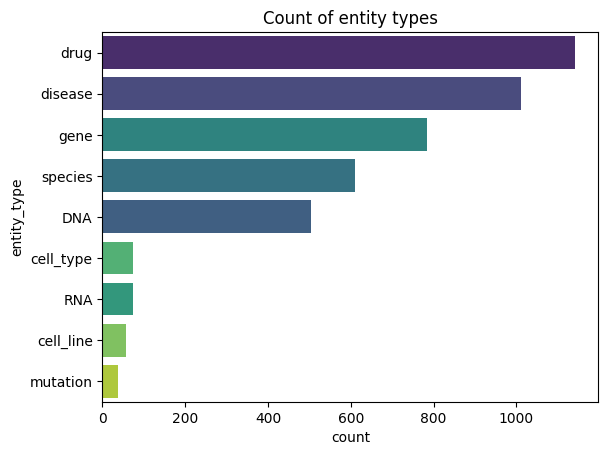

In [ ]:
title_txt = 'Count of entity types'
plot_entity_type(title_txt, entities_only_df_updated)

The most frequently occurring concepts in the dataset are 'drug', 'disease', and 'gene'.

### 5.2 Plot entities

In [ ]:
def plot_sentence_entity_counts(df):
    # Get the count of entities per sha256
    entity_counts = df.groupby('text_sha256')['entity'].count()

    # Create a range of consecutive numbers from min to max of entity counts
    full_range = pd.Series(range(entity_counts.min(), entity_counts.max() + 1))

    # Compute the distribution of entity counts and reindex with the full range
    entity_count_distribution = entity_counts.value_counts().sort_index()

    # Reindex the distribution to include missing counts and fill missing values with 0
    entity_count_distribution = entity_count_distribution.reindex(full_range, fill_value=0)

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=entity_count_distribution.index, hue=entity_count_distribution.index, y=entity_count_distribution.values, palette='viridis', legend=False)
    plt.title('Number of Entities in Sentences', size=12)
    plt.xlabel('Number of Entities', size=10)
    plt.ylabel('Number of Sentences', size=10)
    plt.show()

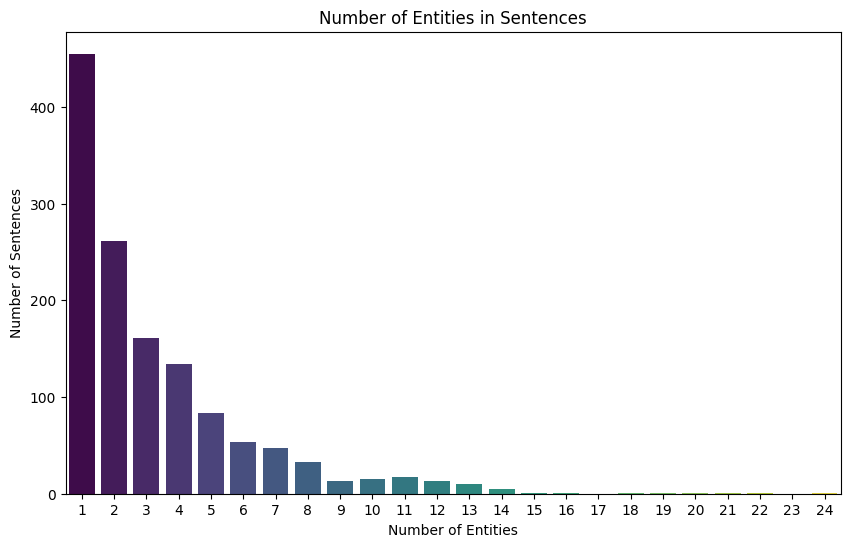

In [ ]:
plot_sentence_entity_counts(entities_only_df_updated)

We can see that most sentences have only one entity, although there is one sentence containing 24 entities.

### References

* Lee, J. et al. (2020). BioBERT: a pre-trained biomedical language representation model for biomedical text mining. *Bioinformatics*, *36*(4), 1234-1240. Oxford University Press. [doi:10.1093/bioinformatics/btz682](https://doi.org/10.1093/bioinformatics/btz682) PMID: 31501885; PMCID: PMC7703786

* BioBERT https://github.com/dmis-lab/biobert

* Kim, D. et al. (2019). A Neural Named Entity Recognition and Multi-Type Normalization Tool for Biomedical Text Mining. In *IEEE Access*, vol. 7, pp. 73729-73740, 2019, [doi:10.1109/ACCESS.2019.2920708](https://doi.org/10.1109/ACCESS.2019.2920708)

* BERN https://github.com/dmis-lab/BERN

* Sung, M. et al. (2022). BERN2: an advanced neural biomedical named entity recognition and normalization tool. *Bioinformatics*, *38*(20), 4837-4839. Oxford University Press. [doi:10.1093/bioinformatics/btac598](https://doi.org/10.1093/bioinformatics/btac598) PMID: 36053172; PMCID: PMC9563680

* BERN2 https://github.com/dmis-lab/BERN2

* Jolly, A. et al. (2024). Exploring Biomedical Named Entity Recognition via SciSpaCy and BioBERT Models. *The Open Biomedical Engineering Journal*, Volume: 18 (2024): e18741207289680, [doi:10.2174/0118741207289680240510045617](http://dx.doi.org/10.2174/0118741207289680240510045617)

* Kim, H. and Kang, J. (2022). How Do Your Biomedical Named Entity Recognition Models Generalize to Novel Entities? In *IEEE Access*, vol. 10, pp. 31513-31523, 2022, [doi:10.1109/ACCESS.2022.3157854](https://doi.org/10.1109/ACCESS.2022.3157854) PMID: 35582496; PMCID: PMC9014470

* Kühnel, L. and Fluck, J. (2022). We are not ready yet: limitations of state-of-the-art disease named entity recognizers. *Journal of Biomedical Semantics*, *13*(1):26, [doi:10.1186/s13326-022-00280-6](https://doi.org/10.1186/s13326-022-00280-6) PMID: 36303237; PMCID: PMC9612606

* https://towardsdatascience.com/construct-a-biomedical-knowledge-graph-with-nlp-1f25eddc54a0

* https://github.com/tomasonjo/blogs/blob/master/bionlp/bioNLP2graph.ipynb

* https://www.thepythoncode.com/article/named-entity-recognition-using-transformers-and-spacy

* https://oyewusiwuraola.medium.com/how-to-use-scispacy-entity-linkers-for-biomedical-named-entities-7cf13b29ef67